## Model description

The model implemented below  accounts for the interactions between the following eight molecular species, leading to eight variables for the ordinary differential (ODE) model:  
- The protein of a generic Aux/IAA, for instance thought of as IAA12/BDL, whose concentration is denoted by $P_{I}$ 
- The protein ARF5/MP, with concentration denoted by $P_{MP}$.
- The isoform protein MP11ir, with concentration denoted by $P_{11}$ .
- Another, generic activator ARF, with protein concentration denoted by $P_{ARF}$.
- The mRNA transcribed from a generic auxin responsive gene under the control of MP, with concentration $R_{MP}$.
- The mRNA transcribed from a generic auxin responsive gene under the control of MP11ir, with concentration $R_{11}$.
- The mRNA transcribed from a generic auxin responsive gene under the control of the generic ARF, with concentration $R_{ARF}$.
- The mRNA transcribed from a generic auxin responsive gene under the control of all three types of ARFs, with concentration $R$.  

In addition, auxin concentration is denoted by $x$, considered purely as an input parameter (i.e. $x$ is not affected by other species). 

The ODE system is then:  
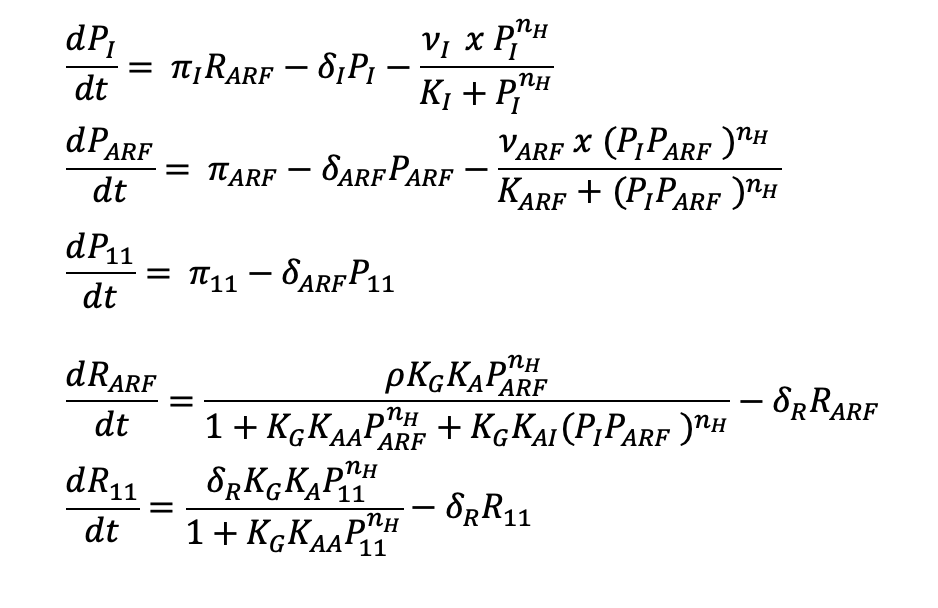

In [2]:
#####################################################################
# Importing required Python libraries            ####################
#####################################################################

# Different options for graphical outputs
%matplotlib notebook
#%pylab inline
#from pylab import *

#%% Import potentially useful packages
import numpy as np  # the famous numpy (arrays, numerics etc.)
import scipy as sp  # the famous scipy (tools for scientific computing)
import matplotlib.pyplot as plt # plotting tools
from scipy.integrate import odeint # an ode time-stepper
from scipy.optimize import least_squares as lsq # a root finder, to locate steady states
from itertools import product as itprod  # a convenience for nested loops
from matplotlib.cm import ScalarMappable # useful for colormaps
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize # idem
from matplotlib.pyplot import cm

In [3]:
#####################################################################
# Just a simple routine to plot time courses.    ####################
#####################################################################

def plotsol(sol, axes, col='k', alpha=1, var=range(5)):
    """
    Plots the solutions, variables vs. time. The variables t, sol and sola 
    are presumably computed via odeint. The boolean withaux determines whether 
    auxin input shall be shown.
    """
        
    # Allocate each subplot
    for j,ax in enumerate(axes.flat):
        if j==0:  # First, auxin
            ax.plot(t,input_aux(t, ),'g', lw=3)
            ax.set_ylabel('Auxin')
        else:     # Next, all model variables, looped for parameter values from previous cell
            ax.plot( t, sol[:,var[j-1]], lw=3, c=col)
            ax.set_ylabel(varnames[var[j-1]], horizontalalignment='right') #,rotation=0
            
    ax.set_xlabel('Time',rotation=0,horizontalalignment='right')



In [4]:
################################################################################
# Define the global parameters which are given default values. #################
################################################################################


# Degradation rates (dimers supposed slowly degraded).
dI= 1  # Aux/IAA protein
dR= 1  # mRNAs
dA= .1 # ARF proteins

# Max transcription rate:
fc= 10.

# Hill exponent (for all ARFs, used in transcription rate):
nh = 2 

varnames= [ 'Aux/IAA', 'ARF', 'MP11ir', 'mRNA\n (ARF resp.)', 'mRNA\n (MP11ir resp.)']

# Parameters
parnames={0:'KIaux',1:'KIARFaux',2:'K12',3:'K22',4:'KAG',5:'fc',6:'VI', 7:'VARF'}

# Some default values
KIaux =   .1
KIARFaux=  1. #0.5#.5
K12, K22, KAG = 1, 10, 1
VI = 5
VARF = 5
p_test1=[KIaux, KIARFaux, K12, K22, KAG, fc, VI, VARF]

# Parameters related to simulations:
t=np.arange(0, 5000, .01);#t=np.arange(0,50000,.1)

x0= .1*np.array(np.random.rand(5))

# A typical parameter set; see names above for interpretation
#p_test=[degraux,1.,1.,1.,d1,HA,fc,HAI,1.,2.] 

# Functions related to auxin input
def input_aux(t):
    return 0.01 + 5*t**2 / (t**2+1000**2) * (2500**6 / (t**6+2500**6) )
#    return phi*(t>0.) #+aux_basal               # step increase
#    return phi*((t>1000)&(t<2500))+aux_basal    # temporary step increase
#    return 1+sin(2*np.pi*t/800.)+aux_basal      # schematized fluctuations


In [5]:
##############################################################
### The main ODE model: ######################################
##############################################################

def fun(x,t,p, AUX=-1): # Inputs: current state, time, parameters, whether to read auxin from input_aux(t)

    if AUX < 0: # auxin input is taken from the globally defined input_aux, unless a nonnegative value is passed
        aux= input_aux(t)
    else: aux = AUX
        
        
    # Michaelis constants
    KIaux = p[0]
    KIARFaux = p[1] 
    
    # Association rates (at equilibrium)
    K12=p[2]
    K22=p[3] 
    KAG=p[4]
    
    # Normalize production rates to keep variables roughly 0≤..≤1
    pI = dI#degraux #
    pA = dA#degraux #  #5. #  ARFs constitutive production
    
    # Transcriptional rates maximum
    fc = p[5]
    
    # Max degradation of Aux/IAA and MP, respectively
    VI  = p[6]
    VARF = p[7]
    
    # Auxin regulated degradation rates (including basal):
    dIx = dI + VI*aux*x[0]**(nh-1)/(KIaux**nh + x[0]**nh)
    dAx = dA + VARF*aux*(x[0]**nh)*x[1]**(nh-1)/(KIARFaux + (x[0]*x[1])**nh)
    
    f0= pI*x[3] - dIx * x[0]  # Aux/IAA protein
    
    f1= pA      - dAx * x[1]  # ARF protein
    
    f2= pA      - dA  * x[2]  # MP11ir isoform; no Aux/IAA binding nor regulated degradation
    
    # Pure ARF target:
    f3= fc*( 10*KAG*K22*x[1]**nh )/(1. + 10*KAG*K22*x[1]**nh + KAG*K12*(x[0]*x[1])**nh ) - dR*x[3]
    
    # Pure MP11ir target:
    f4= fc*( KAG*K22*x[2]**nh )/(1. + KAG*K22*x[2]**nh ) - dR*x[4]
    
     
    return [f0, f1, f2, f3, f4]


## Calculate steady states directly, using a least square method
def stst(aux, x0=x0, p_test=p_test1): #, full_model = 1):
    Xs = lsq( lambda x:fun(x,0,p_test, AUX=aux), x0, bounds=(0,np.inf) , max_nfev=1e4 )
    return Xs.success, Xs.x


<IPython.core.display.Javascript object>


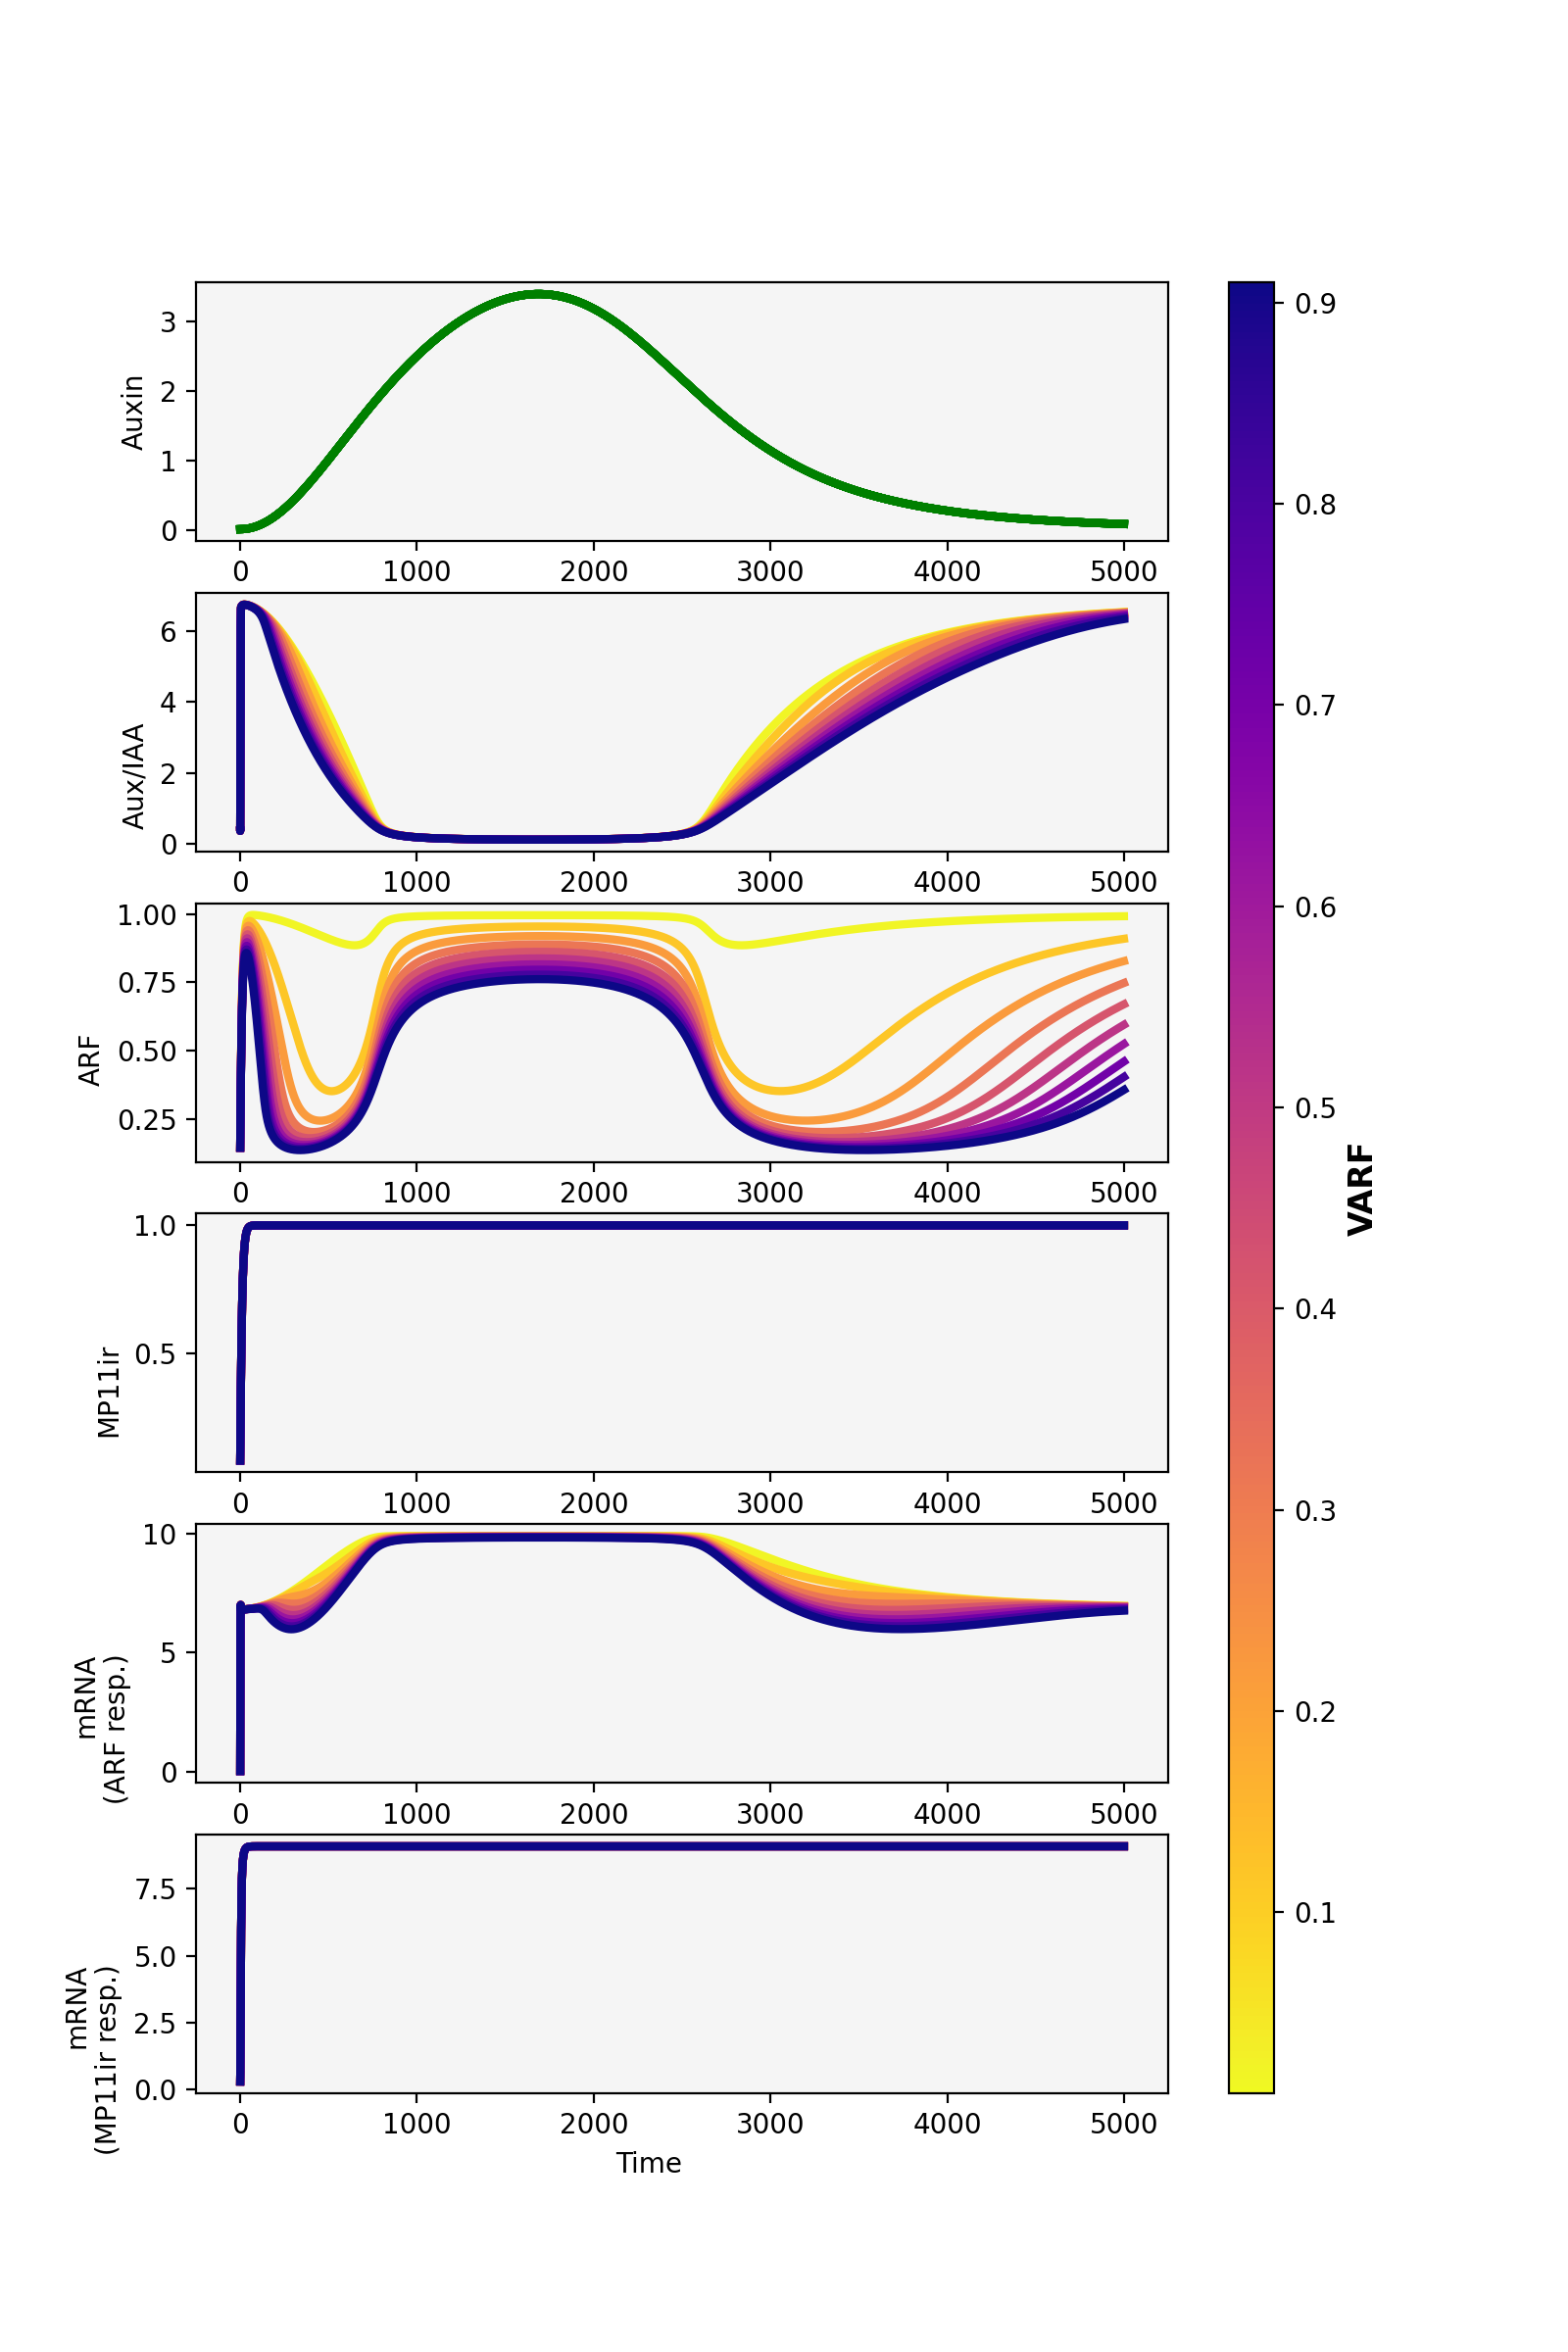

In [6]:
##############################################################
### Calculate and plot time courses.        ##################
##############################################################


# Create a figure handle
fig, axes = plt.subplots(nrows=6,ncols=1)
#fig, axes = plt.subplots(nrows=4,ncols=1) ## To plot only non-MP11ir variables
fig.set_facecolor('white')
fig.set_size_inches(8, 12)#, forward = False) 
[ax.set_facecolor('whitesmoke') for ax in axes]

# Initial condition
X0  = np.array(.5*np.random.rand(5))

# Main loop: select one parameter and give it a range of values. Then compute & plot time courses.
V = [0.01+VARF*j*.02 for j in range(10)] #
ip = 7# the parameter position in p_test1 and parnames

for v in V:
    p_test1[ip]=v
    fy = odeint(fun,X0,t,(p_test1,))
    plotsol(fy,axes=axes, col=cm.plasma_r(v/np.max(V)), alpha=.6)
    #plotsol(fy,axes=axes, col=cm.plasma_r(v/np.max(V)), alpha=.6, var=[0,1,3])## To plot only non-MP11ir variables

if len(V)>1:   
    # Create a colorbar and display it on the side, for the chosen range of parameter values
    cbar= fig.colorbar(ScalarMappable(norm= Normalize(vmin=V[0], vmax=V[-1]), cmap=cm.plasma_r), 
                       ax=axes.ravel().tolist(), aspect=40)
    cbar.ax.tick_params(labelsize=10) 
    cbar.set_label(label=parnames[ip], size='large', weight='bold')
    #plt.tight_layout()

In [7]:
########################################################################################
### Calculate steady states for a range of auxin inputs and parameter values.        ###
########################################################################################

Ns = 500 # Number of auxin values being sampled
# We make aux range from 0 to 5, with half the sample between 0 and 1 where things move faster:
aux_s = np.concatenate( (np.linspace(0, 1, int(Ns/2) ), np.linspace(1, 5, int(Ns/2)) ) )

# Main loop: select one parameter and give it a range of values. Then compute & plot time courses.
V = [0.01+VARF*j*.02 for j in range(10)] #
Np = len(V) # number of parameter valus
ip = 7# the parameter position in p_test1 and parnames

# An empty array, to be filled with steady state values
Xs1 = np.zeros( (5, Ns, Np) )

for j in range(Np):
    ps = V[j]
    for i in range(Ns):
        # Set the parameters
        #KIaux, KIMaux = 1, 10
        #VI, VMP = 5, 5
        p_test1[ip] = ps
        if i==0:
            # Start with the default initial guess
            tmp = stst( aux_s[i], p_test=p_test1)
        else:
            # At each step, use the previous steady state as initial guess
            tmp = stst( aux_s[i], x0=Xs1[:,i-1,j], p_test=p_test1)
        if tmp[0]: Xs1[:,i,j] = tmp[1]

In [32]:
#############################################################################
### Plot steady states for a range of auxin inputs and parameter values.  ###
#############################################################################


def plot_steady_states(Xs1=Xs1, aux_s=aux_s, var=range(len(Xs1)), parvals=V, ip=ip):

    Np = Xs1.shape[2]
    # Colours as a parameter takes the chosen range of values
    custom_palette = [plt.cm.plasma_r(i/Np) for i in range(Np)]

    fig, axes = plt.subplots(nrows=len(var), ncols=1)
    fig.set_facecolor('white')
    fig.set_size_inches(3*len(var), 8)  
    
    # Allocate each subplot
    for j,ax in enumerate(axes.flat):
        for i in range(Np):
                ax.plot( aux_s, Xs1[var[j],:,i], lw=2, c=custom_palette[i])
                ax.set_ylim(0, np.max(Xs1[var[j],:])*1.1 )
                ax.set_ylabel(varnames[var[j]])
    ax.set_xlabel('Auxin')

    # Create a colorbar and display it on the side, for the chosen range of parameter values
    cbar= fig.colorbar(#ScalarMappable(norm=BoundaryNorm(parvals,ncolors=Np), cmap=ListedColormap(custom_palette)),
                       ScalarMappable(norm= Normalize(vmin=parvals[0], vmax=parvals[-1]), cmap=cm.plasma_r), 
                        ax=axes.ravel().tolist(), aspect=40)
    cbar.ax.tick_params(labelsize=10) 
    cbar.set_label(label=parnames[ip], size='large', weight='bold')


<IPython.core.display.Javascript object>


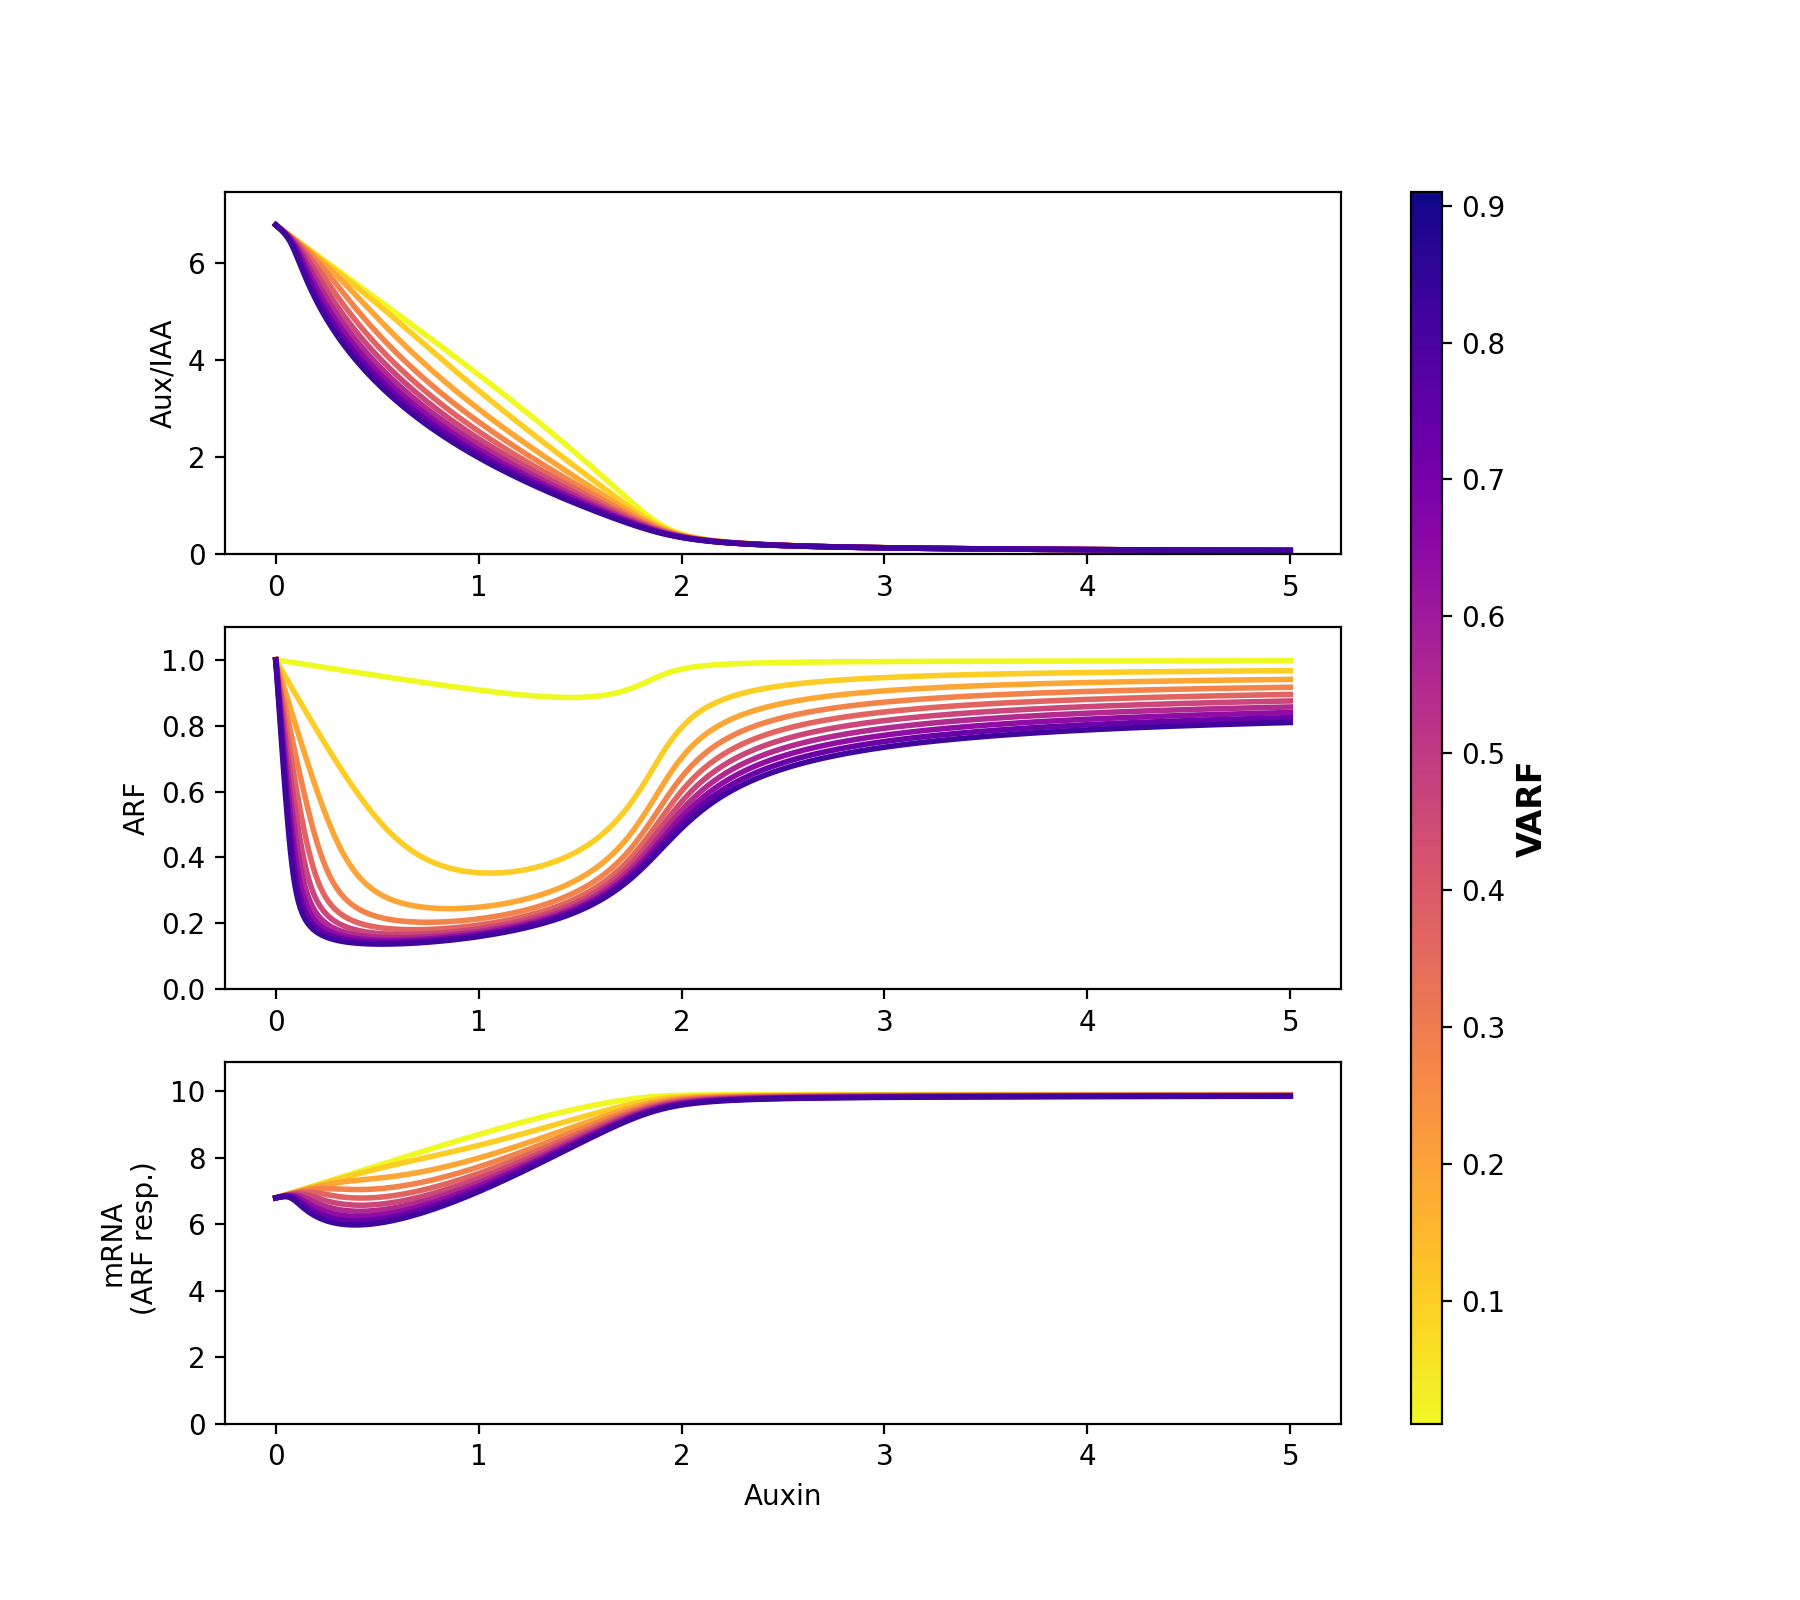

In [33]:
plot_steady_states(var = [0,1,3])

<IPython.core.display.Javascript object>


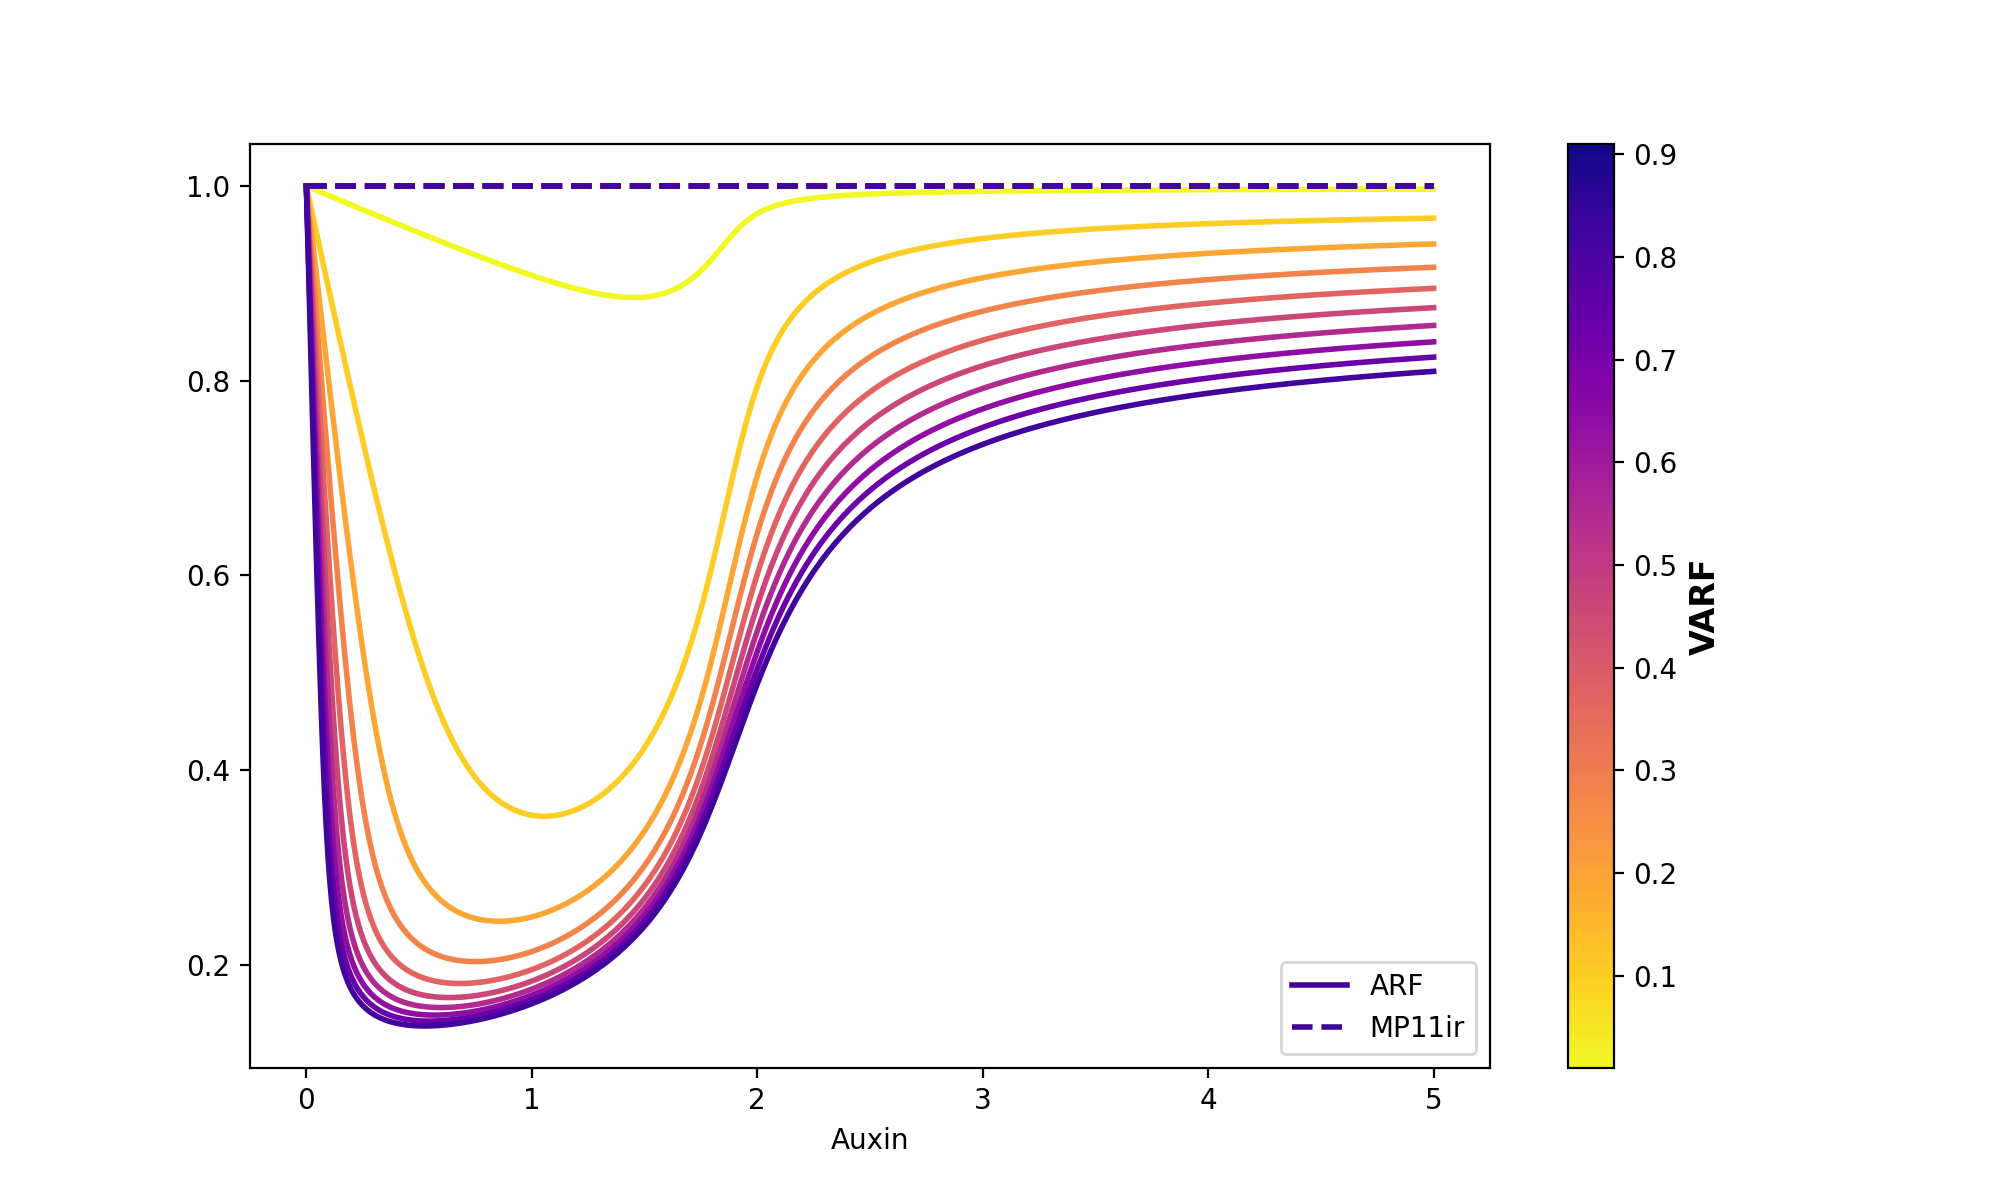

In [45]:
## Create a separate figure just for ARF and MP11ir shown in the same plot
fig = plt.figure(figsize=(10,6))
custom_palette = [plt.cm.plasma_r(i/Np) for i in range(Np)]
for j in [1,2]:
    mrkr = '-'
    for i in range(Np):
        if j==2:
            mrkr = '--'
            #custom_palette = [plt.cm.viridis(i/Np) for i in range(Np)]
        
        if i == Np-1:
            plt.plot( aux_s, Xs1[j,:,i], mrkr,lw=2, c=custom_palette[i], label=varnames[j])
        else:
            plt.plot( aux_s, Xs1[j,:,i], mrkr,lw=2, c=custom_palette[i])
            
        #plt.set_ylim(0, np.max(Xs1[var[j],:])*1.1 )
plt.xlabel('Auxin')
plt.legend()
cbar= fig.colorbar(ScalarMappable(norm= Normalize(vmin=V[0], vmax=V[-1]), cmap=cm.plasma_r))#,ax=fig.axes[0].ravel().tolist(), aspect=40)
cbar.ax.tick_params(labelsize=10) 
cbar.set_label(label=parnames[ip], size='large', weight='bold')